# Lab 11- Extended Exercises on Time Series Clustering

You are the Senior Data Scientist in a learning platform called LernTime. Your data science team built a data frame in which each row contains the aggregated features per student (calculated over the first 5 weeks of interactions) and the feature `dropout` indicates whether the student stopped using the platform (1) or not (0) before week 10.

The dataframe is in the file `lerntime.csv` and contains the following features:
- `video_time`: total video time (in minutes) 
- `num_sessions` total number of sessions
- `num_quizzes`: total number of quizzes attempts
- `reading_time`: total theory reading time
- `previous_knowledge`: standardized previous knowledge
- `browser_speed`: standardized browser speed
- `device`:  whether the student logged in using a smartphone (1) or a computer (-1)
- `topics`: the topics covered by the user
- `education`: current level of education (0: middle school, 1: high school, 2: bachelor, 3: master, 4: Ph.D.).
- `dropout`: whether the student stopped using the platform (1) or not (0) before week 5.

In [1]:
import pandas as pd


# Data directory
DATA_DIR = "./../../data/"

In [2]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lab-11',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

Your name:   


In [4]:
df = pd.read_csv(f'{DATA_DIR}/lerntime_dropout.csv')

In [5]:
df.head()

,video_time,num_sessions,num_quizzes,reading_time,previous_knowledge,browser_speed,device,topics,education,dropout
0,45.793303,99.0,36.0,48.186562,1.675972,-0.294704,1.0,"['Locke', 'Descartes', 'Socrates', 'Kant', 'Ni...",2.0,0
1,51.331242,57.0,12.0,49.945810,0.700522,1.253694,1.0,"['Nietzche', 'Locke', 'Confucius', 'Aristotle'...",3.0,0
2,87.414834,52.0,7.0,20.611978,1.836716,-1.171352,1.0,"['Plato', 'Locke', 'Nietzche', 'Socrates', 'De...",4.0,0
3,58.556388,47.0,31.0,33.785805,0.209577,-2.043047,1.0,"['Aristotle', 'Socrates', 'Plato', 'Confucius'...",3.0,0
4,74.822362,58.0,37.0,38.907983,0.265678,-0.754559,1.0,"['Kant', 'Aristotle', 'Confucius', 'Locke', 'P...",4.0,0


You decide to explore the different type of users. You want to use your knowledge from your ML4BD course and decide to cluster using Spectral Clustering. 
In the course, you learnt different ways of constructing the similarity graph, yielding the adjacency matrix serving as an input to the Spectral Clustering. 
Based on your in-depth exploration of the data, you decide to construct the similarity graph as a  *k-nearest neighbor graph*.

Your tasks are to:

a) Write a function to compute the k-nearest neighbor graph.

b) Cluster the users using Spectral Clustering and your k-nearest neighbor graph function (use 4 neighbors). Use only the features *reading_time* and *topics*. You can assume that optimal number of clusters is 2.


## a) Computation of the k-nearest neighbor graph 
Unfortunately, there is no k-nearest neighbor graph implementation available in scikit-learn and you therefore have to implement the function yourself.

The function `'k_nearest_neighbor_graph'` takes a similarity matrix `S` as well as the number of neighbors `k` as an input an returns the adjacency matrix `W`.

Note that we will not evaluate the coding efficiency of your function. 

In [6]:
import numpy as np

In [7]:
def k_nearest_neighbor_graph(S, k):
    # S: similarity matrix
    # k: number of neighbors
    S = np.array(S)
    neighbours = []
    
    for item in S:
        idx = np.argpartition(item, k)
        neighbours.append([1 if i in idx[:k] else 0 for i in range(len(item))])
    
    W = np.zeros(S.shape)
    for i in range(len(W)):
        for j in range(len(W)):
            W[i][j] = S[i][j] if neighbours[i][j] or neighbours[j][i] else 0
            
    return W

In [8]:
# Solution
# G = kneighbours_graph(-S + S.max(), k+1, metric='precomputed', mode='connectivity', include_self=True).toarray()

In [9]:
k = 2
# Please run this cell for evaluation purposes
S = [[1, 0.2, 0.7, 0.1],
     [0.2, 1, 0.8, 0.4],
     [0.7, 0.8, 1, 0.6],
     [0.1, 0.4, 0.6, 1]]

a = k_nearest_neighbor_graph(S, k)
print(a)
send(a, 1)

[[0.  0.2 0.7 0.1]
 [0.2 0.  0.  0.4]
 [0.7 0.  0.  0.6]
 [0.1 0.4 0.6 0. ]]


<Response [200]>

In [10]:
# Please run this cell for evaluation purposes
S = [[1, 0.3, 0.01, 0.1],
     [0.3, 1, 0.8, 0.9],
     [0.01, 0.8, 1, 0.6],
     [0.1, 0.9, 0.6, 1]]

k_nearest_neighbor_graph(S, k)
a = k_nearest_neighbor_graph(S, k)
print(a)
send(a, 2)

[[0.   0.3  0.01 0.1 ]
 [0.3  0.   0.8  0.  ]
 [0.01 0.8  0.   0.6 ]
 [0.1  0.   0.6  0.  ]]


<Response [200]>

## b) Spectral Clustering 
Perform a spectral clustering using a k-nearest neighbor graph (with 4 neighbors). 

Use the two features `reading_time` and `topics` only. 

If you did not manage to solve task a), use a *fully connected graph* as similarity graph to obtain the adjacency matrix `W`. 

You can assume that the optimal number of clusters is 2. 

Print the obtained cluster labels. 

In [11]:
#Important imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.metrics import cdist_dtw
from sklearn.preprocessing import StandardScaler

from scipy.spatial import distance
from scipy.sparse.csgraph import laplacian
from scipy import linalg
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import spectral_embedding

In [12]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity 
    :return: adjacency matrix
    """
    
    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')
        
    return adjacency

In [13]:
def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues 
        
    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

In [14]:
def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    
    :param n_clusters_list: List of number of clusters to explore 
    :param metric_dictionary: 
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1

In [15]:
def get_heuristics_spectral(W, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering
    
    :param W: np array of adjacency matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    eigengap_list = []
    
    df_labels = pd.DataFrame()

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)
        y_pred = kmeans.labels_
        df_labels[str(k)] = y_pred

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }
    
    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
        return df_labels
    else:
        return df_labels, metric_dictionary

In [16]:
def view_clusters(data, labels, ylim = 70, xlabel= 'Biweeks'):
    """
    visualize the different time-series of students belonging to each cluster. 
    :param data: np.array with students' time-series
    :param labels: np.array predicted labels from clustering model
    :return: 
    """
    _, biweeks = data.shape
    clusters = np.unique(labels).shape[0]
    fig, axs = plt.subplots(1, clusters, figsize=(16, 4), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    for i in range(clusters):
        students_cluster = data[labels == i]
        number_students = students_cluster.shape[0]
        for student in range(number_students):
            axs[i].bar(range(biweeks), students_cluster[student], alpha=0.3)
        
        axs[i].set_ylim([0, ylim])
        axs[i].set_title('Group {0}'.format(i))
        axs[i].set_ylabel('Hours using platform')
        axs[i].set_xlabel(xlabel)

In [17]:
def plot_students_group(data, labels):
    """
    Plot the students time-series
    :param data: np.array with students' time-series
    :param labels: pd.Series indicating the labels of the students
    :return: 
    """
    for group in np.unique(labels):
        subdata = data[labels==group]
        subindex = labels[labels==group].index
        students, biweeks = subdata.shape

        rows = int(np.ceil(students/6))
        fig, axs = plt.subplots(rows, 6, figsize=(16, rows*3), sharex=True,
                            sharey=True, facecolor='w', edgecolor='k')

        axs = axs.ravel()
        for i in range(students):
            axs[i].bar(range(biweeks), subdata[i], alpha=0.8)
            axs[i].set_ylim([0, 50])
            axs[i].set_title('Student {0}'.format(subindex[i]))
        
        fig.suptitle('GROUP {}'.format(group))
        fig.supxlabel('Biweek')
        fig.supylabel('Usage of platform (hours)')
        plt.tight_layout()
        plt.show()

In [18]:
X = df[['reading_time','topics']]
X

,reading_time,topics
0,48.186562,"['Locke', 'Descartes', 'Socrates', 'Kant', 'Ni..."
1,49.945810,"['Nietzche', 'Locke', 'Confucius', 'Aristotle'..."
2,20.611978,"['Plato', 'Locke', 'Nietzche', 'Socrates', 'De..."
3,33.785805,"['Aristotle', 'Socrates', 'Plato', 'Confucius'..."
4,38.907983,"['Kant', 'Aristotle', 'Confucius', 'Locke', 'P..."
...,...,...
295,32.590844,"['Aristotle', 'Confucius', 'Plato', 'Kant', 'N..."
296,42.503553,"['Confucius', 'Descartes', 'Kant', 'Locke', 'S..."
297,56.969505,"['Socrates', 'Plato', 'Descartes', 'Aristotle'..."
298,67.457289,"['Plato', 'Socrates', 'Locke', 'Aristotle', 'K..."


In [19]:
X['topics'][0].replace("'", "").replace('[','').replace(']','').split(", ")

['Locke',
 'Descartes',
 'Socrates',
 'Kant',
 'Nietzche',
 'Confucius',
 'Aristotle',
 'Plato']

In [20]:
S_reading_time = pairwise_kernels(X[['reading_time']], metric='rbf', gamma=1)
S_reading_time

array([[1.00000000e+000, 4.52770721e-002, 0.00000000e+000, ...,
        3.15125400e-034, 5.24800016e-162, 0.00000000e+000],
       [4.52770721e-002, 1.00000000e+000, 0.00000000e+000, ...,
        3.76060768e-022, 6.64921189e-134, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 7.88239994e-001],
       ...,
       [3.15125400e-034, 3.76060768e-022, 0.00000000e+000, ...,
        1.00000000e+000, 1.69972568e-048, 0.00000000e+000],
       [5.24800016e-162, 6.64921189e-134, 0.00000000e+000, ...,
        1.69972568e-048, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 7.88239994e-001, ...,
        0.00000000e+000, 0.00000000e+000, 1.00000000e+000]])

In [21]:
def jaccard_difference(l1, l2):
    l1 = set(l1)
    l2 = set(l2)

    return 1 -  (len(l1.intersection(l2)) / len(l1.union(l2)) )

In [22]:
S_topics = []
for s1 in X['topics']:
    entry = []
    for s2 in X['topics']:
        entry.append(jaccard_difference(s1,s2))
    S_topics.append(entry)
    
S_topics = np.array(S_topics)
S_topics

array([[0.        , 0.03571429, 0.03571429, ..., 0.10714286, 0.25      ,
        0.03571429],
       [0.03571429, 0.        , 0.        , ..., 0.07407407, 0.28571429,
        0.07142857],
       [0.03571429, 0.        , 0.        , ..., 0.07407407, 0.28571429,
        0.07142857],
       ...,
       [0.10714286, 0.07407407, 0.07407407, ..., 0.        , 0.35714286,
        0.14285714],
       [0.25      , 0.28571429, 0.28571429, ..., 0.35714286, 0.        ,
        0.22222222],
       [0.03571429, 0.07142857, 0.07142857, ..., 0.14285714, 0.22222222,
        0.        ]])

In [23]:
# S_topics = pairwise_kernels(X[['topics']], metric=jaccard_difference)
# S_topics
# ValueError: could not convert string to float: "['Locke', 'Descartes', 'Socrates', 'Kant', 'Nietzche', 'Confucius', 'Aristotle', 'Plato']"


In [24]:
# TODO normalize before summing or averaging?

S = np.add(S_reading_time,S_topics)
S

array([[1.        , 0.08099136, 0.03571429, ..., 0.10714286, 0.25      ,
        0.03571429],
       [0.08099136, 1.        , 0.        , ..., 0.07407407, 0.28571429,
        0.07142857],
       [0.03571429, 0.        , 1.        , ..., 0.07407407, 0.28571429,
        0.85966857],
       ...,
       [0.10714286, 0.07407407, 0.07407407, ..., 1.        , 0.35714286,
        0.14285714],
       [0.25      , 0.28571429, 0.28571429, ..., 0.35714286, 1.        ,
        0.22222222],
       [0.03571429, 0.07142857, 0.85966857, ..., 0.14285714, 0.22222222,
        1.        ]])

In [25]:
# W =  get_adjacency(S) 
W = k_nearest_neighbor_graph(S, 4)

In [26]:
W = np.array(W)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold

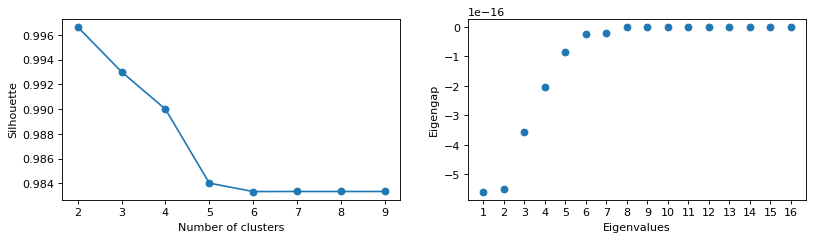

In [27]:
n_cluster_list = range(2, 10)
df_labels = get_heuristics_spectral(W, n_cluster_list)

In [99]:
list(df_labels['2'])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


In [84]:
cluster_labels = list(df_labels['2'])
send(cluster_labels, 3)

<Response [200]>